# Projekt 01: Analiza danych medycznych z wykorzystaniem tradycyjnych metod uczenia maszynowego

## Analiza zbioru danych ae_retro

### Import bibliotek

In [119]:
%matplotlib inline

import numpy as np
from pandas import DataFrame
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


### Wczytanie i transformacja danych

In [120]:
def transform_num(value: str) -> float | str:
  def is_num(value: str) -> bool:
    try:
      float(str(value).replace(',', '.'))
      return True
    except ValueError:
      return False

  def as_num(value: str) -> float:
    return float(str(value).replace(',', '.'))

  match value:
    case _ if is_num(value): return as_num(value)
    case _: return value

def transform_bool(value: str) -> bool | str:
  match value:
    case 'YES': return True
    case 'NO': return False
    case _: return value

def transform_category(value: str) -> bool:
  return value != 'SHORT'

In [121]:
dataframe = pd.read_csv('resources/datasets/ae_retro/discretized.csv', na_values=('?',))

attribute_key_map = {
  'REG_AGE': 'registartion_age',
  'PRIM_CARE': 'primary_care',
  'CHEST_CLINIC': 'chest_clinic',
  'CURR_INH_STEROID': 'current_inhaled_steroids',
  'AGE_FIRST_SX': 'age_of_first_symptoms',
  'PREV_ORAL_STEROID': 'previous_oral_steroids',
  'PREV_ED_LAST_YEAR': 'previous_ed_last_year',
  'PREV_ADM': 'previous_admission',
  'ENV_SMOKE': 'smokey_environment',
  'ENV_DANDER': 'dander_in_environment',
  'ENV_CARPETS': 'carpets_in_environment',
  'ALLG_ENV': 'allergic_environment',
  'ALLG_PETS': 'allergric_pets',
  'ALLG_FOOD': 'allergic_food',
  'PTHX_ATOPY': 'PTHX_atopy',
  'FMHX_ASTHMA': 'FMHX_asthma',
  'ALLG_EXP': 'allergy_exposure',
  'URTI_SX': 'URTI_symptoms',
  'FEVER': 'fever',
  'DUR_ASTHMA_SX': 'duration_of_symptoms',
  'VENT_LAST_24H': 'ventilation_in_last_24h',
  'ARRV_ED': 'arrival_to_ed',
  'CORR_CATEGORY': 'category',
  'TRIAGE_TEMP': 'triage_temperature',
  'TRIAGE_RESP_RATE': 'triage_respiratory_rate',
  'TRIAGE_HEART_RATE': 'triage_heart_rate',
  'TRIAGE_SAO2': 'triage_oxygen_saturation',
  'TRIAGE_SAO2_ENV': 'triage_oxygen_environment',
  'TRIAGE_AIR_ENTRY': 'triage_air_entry',
  'TRIAGE_DISTRESS': 'triage_distress',
  'TRIAGE_COLOUR': 'triage_skin_colour',
  'TRIAGE_EXP_WHEEZE': 'triage_expiratory_wheeze',
  'TRIAGE_INSP_WHEEZE': 'triage_inspiratory_wheeze',
  'TRIAGE_RETRACTIONS': 'triage_retractions',
  'REASS_TEMP': 'reassesment_temperature',
  'REASS_RESP_RATE': 'reassesment_respiratory_rate',
  'REASS_HEART_RATE': 'reassesment_heart_rate',
  'REASS_SAO2': 'reassesment_oxygen_saturation',
  'REASS_SAO2_ENV': 'reassesment_oxygen_environment',
  'REASS_AIR_ENTRY': 'reassesment_air_entry',
  'REASS_DISTRESS': 'reassesment_distress',
  'REASS_COLOUR': 'reassesment_skin_colour',
  'REASS_EXP_WHEEZE': 'reassesment_expiratory_wheeze',
  'REASS_INSP_WHEEZE': 'reassesment_inspiratory_wheeze',
  'REASS_RETRACTIONS': 'reassesment_retractions',
  'REASS_RX_TYPE': 'reassesment_treatment_type',
  'RX_OTHER': 'treatment_other',
}

dataframe = (
  dataframe[dataframe['DECISION_OFFSET'] == 60]
  .drop(columns=['DECISION_OFFSET'])
  .rename(columns=attribute_key_map)
  .map(transform_num)
  .map(transform_bool)
)

dataframe['category'] = dataframe['category'].map(transform_category)

### Analiza danych - Przedstawienie zbioru

In [122]:
dataframe.head()

,registartion_age,primary_care,chest_clinic,current_inhaled_steroids,age_of_first_symptoms,previous_oral_steroids,previous_ed_last_year,previous_admission,smokey_environment,dander_in_environment,...,reassesment_heart_rate,reassesment_oxygen_saturation,reassesment_air_entry,reassesment_distress,reassesment_skin_colour,reassesment_expiratory_wheeze,reassesment_inspiratory_wheeze,reassesment_retractions,NUM_MASKS,category
0,GE_3Y_LT_7Y,FD,False,NaN,GE_1Y_LT_3Y,GE_1M_LT_3M,2_VISITS,FLOOR,NaN,NaN,...,NORMAL,NaN,NaN,NONE,PINK,PRESENT,PRESENT,NaN,0.0,True
1,GE_3Y_LT_7Y,FD,False,PRN,GE_3Y,GE_12M,NONE,NONE,NaN,NaN,...,NaN,GE_93_LT_95,GOOD,NaN,NaN,ABSENT,ABSENT,ABSENT,1.0,False
4,GE_3Y_LT_7Y,FD,True,PRN,GE_1Y_LT_3Y,GE_3M_LT_12M,GE_4_VISITS,FLOOR,NaN,NaN,...,NaN,NaN,GOOD,NaN,NaN,ABSENT,ABSENT,PRESENT,1.0,False
5,GE_3Y_LT_7Y,FD,True,PRN,GE_1Y_LT_3Y,GE_3M_LT_12M,GE_4_VISITS,FLOOR,NaN,NaN,...,ABNORMAL,GE_93_LT_95,GOOD,NaN,PALE,PRESENT,PRESENT,PRESENT,3.0,True
7,GE_7Y,FD,False,NONE,GE_3Y,GE_3M_LT_12M,2_VISITS,NONE,NaN,NaN,...,NaN,NaN,REDUCED,NONE,NaN,PRESENT,NaN,PRESENT,1.0,False


#### Wykresy

In [123]:
def show_missing_values(dataframe: DataFrame):
  dataframe = (
    dataframe
    .isnull()
    .sum()
    .reset_index()
    .rename(columns={
      'index': 'column_name',
      0: 'counts',
    })
    .sort_values('counts')
    .query('counts > 0')
  )

  figure = plt.figure(figsize=(24, 10))

  axis = sns.barplot(
    x='counts',
    y='column_name',
    data=dataframe,
    palette='muted', hue='column_name',
    figure=figure
  )
  for bar in axis.containers: axis.bar_label(bar)

  axis.set(
    title='Missing Values',
    xlabel='Count',
    ylabel='Column Name'
  )
  figure.show()

def show_correlation(dataframe: DataFrame):
  dataframe = dataframe.copy(deep=True)

  categorical_columns = [
    # 'chest_clinic'
    # 'number_of_masks'
    # 'triage_oxygen_environment',
    # 'reassesment_oxygen_environment',
    # 'treatment_type',
    # 'treatment_other'
    'registartion_age',
    'primary_care',
    'current_inhaled_steroids',
    'age_of_first_symptoms',
    'previous_oral_steroids',
    'previous_ed_last_year',
    'previous_admission',
    'smokey_environment',
    'dander_in_environment',
    'carpets_in_environment',
    'allergic_environment',
    'allergric_pets',
    'allergic_food',
    'PTHX_atopy',
    'FMHX_asthma',
    'allergy_exposure',
    'URTI_symptoms',
    'fever',
    'duration_of_symptoms',
    'ventilation_in_last_24h',
    'arrival_to_ed',
    'triage_temperature',
    'triage_respiratory_rate',
    'triage_heart_rate',
    'triage_oxygen_saturation',
    'triage_air_entry',
    'triage_distress',
    'triage_skin_colour',
    'triage_expiratory_wheeze',
    'triage_inspiratory_wheeze',
    'triage_retractions',
    'reassesment_temperature',
    'reassesment_respiratory_rate',
    'reassesment_heart_rate',
    'reassesment_oxygen_saturation',
    'reassesment_air_entry',
    'reassesment_distress',
    'reassesment_skin_colour',
    'reassesment_expiratory_wheeze',
    'reassesment_inspiratory_wheeze',
    'reassesment_retractions',
  ]
  for column in categorical_columns:
    dataframe[column] = dataframe[column].astype('category').cat.codes

  figure = plt.figure(figsize=(24, 24))
  axis = sns.heatmap(dataframe.corr(
    method='kendall'
  ), annot=True, fmt='.2f', cmap='coolwarm', ax=figure.gca())
  axis.set_title('Correlation')
  figure.show()

def show_distribution(dataframe: DataFrame):
  dataframe = (
    dataframe['category']
    .reset_index()
    .groupby('category')
    .size()
    .to_frame()
    .rename(columns={
      'index': 'category',
      0: 'counts'
    })
  )

  figure = plt.figure(figsize=(8, 4))

  axis = sns.barplot(
    x='category',
    y='counts',
    data=dataframe,
    palette='muted',
    hue='category',
    figure=figure
  )

  for bar in axis.containers: axis.bar_label(bar)
  axis.set(
    title='Distribution',
    xlabel='Category',
    ylabel='Count',
    xticks=[0, 1],
    xticklabels=['Short', 'Admitted+Long']
  )
  figure.show()

#### Wykresy - brakujące wartości
Wykres przedstawiający ilość brakujących wartości w poszczególnych kolumnach.

C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_34836\267930863.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


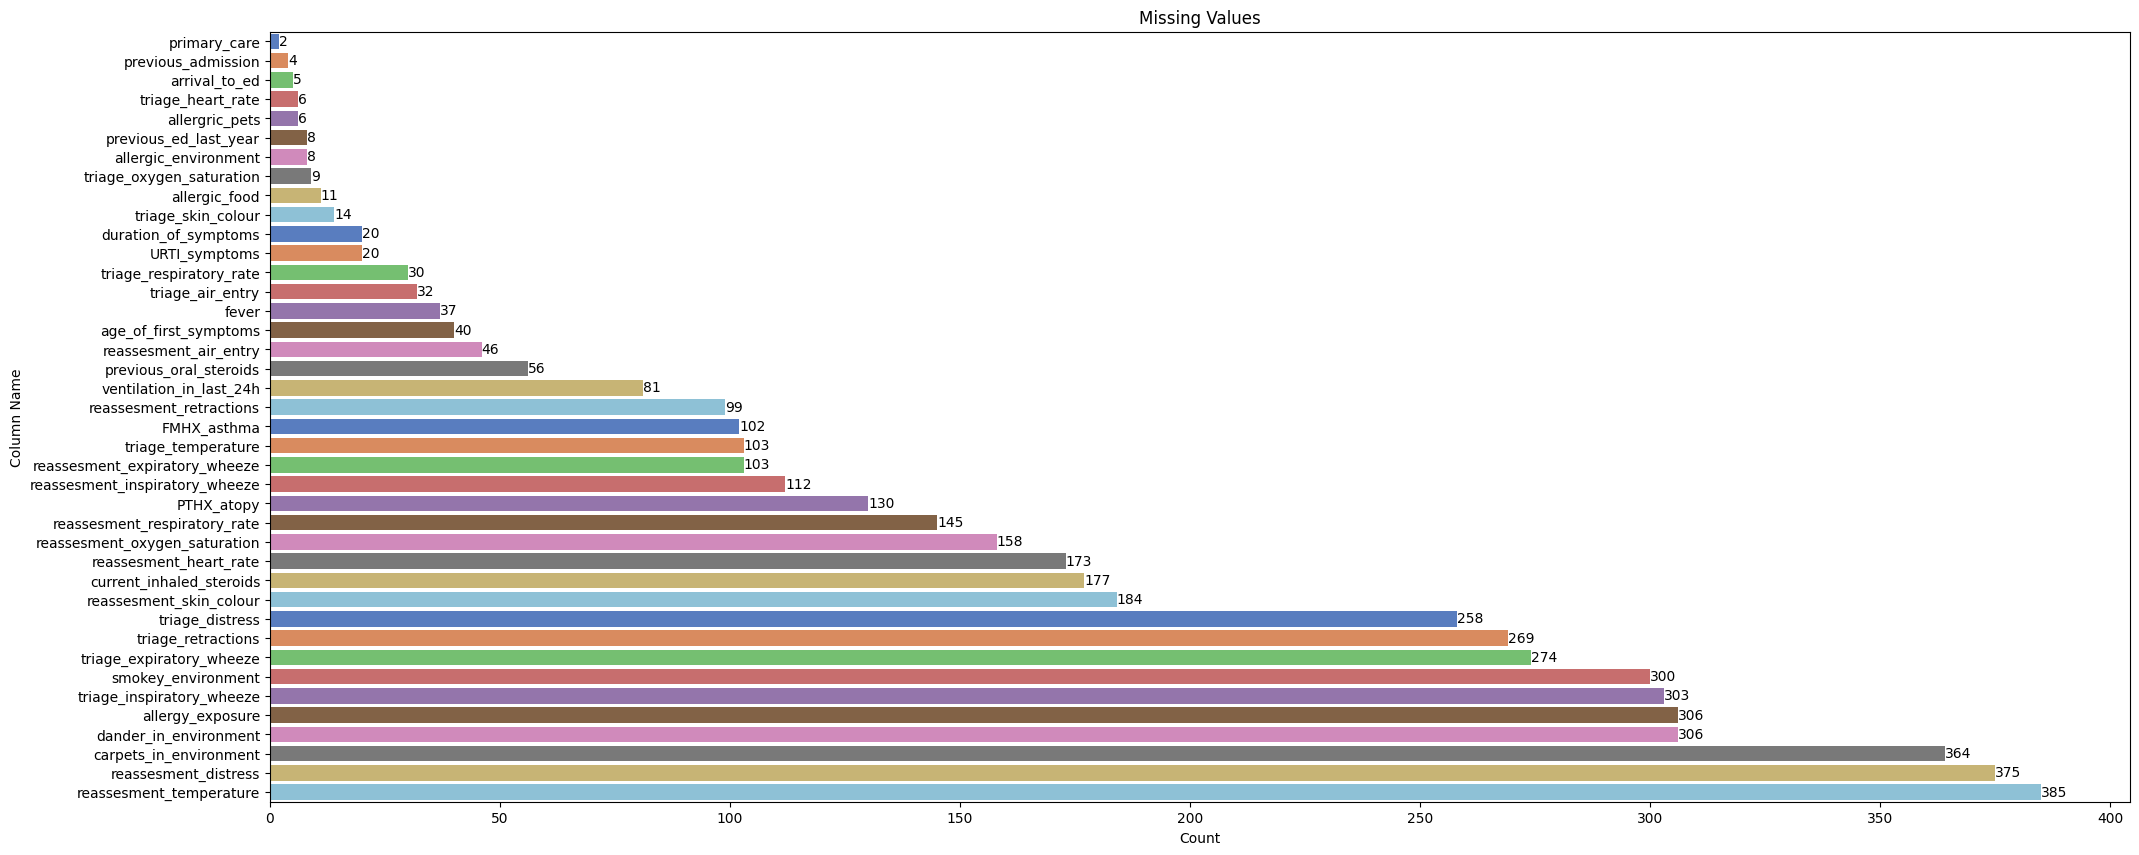

In [124]:
show_missing_values(dataframe)

C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_34836\267930863.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


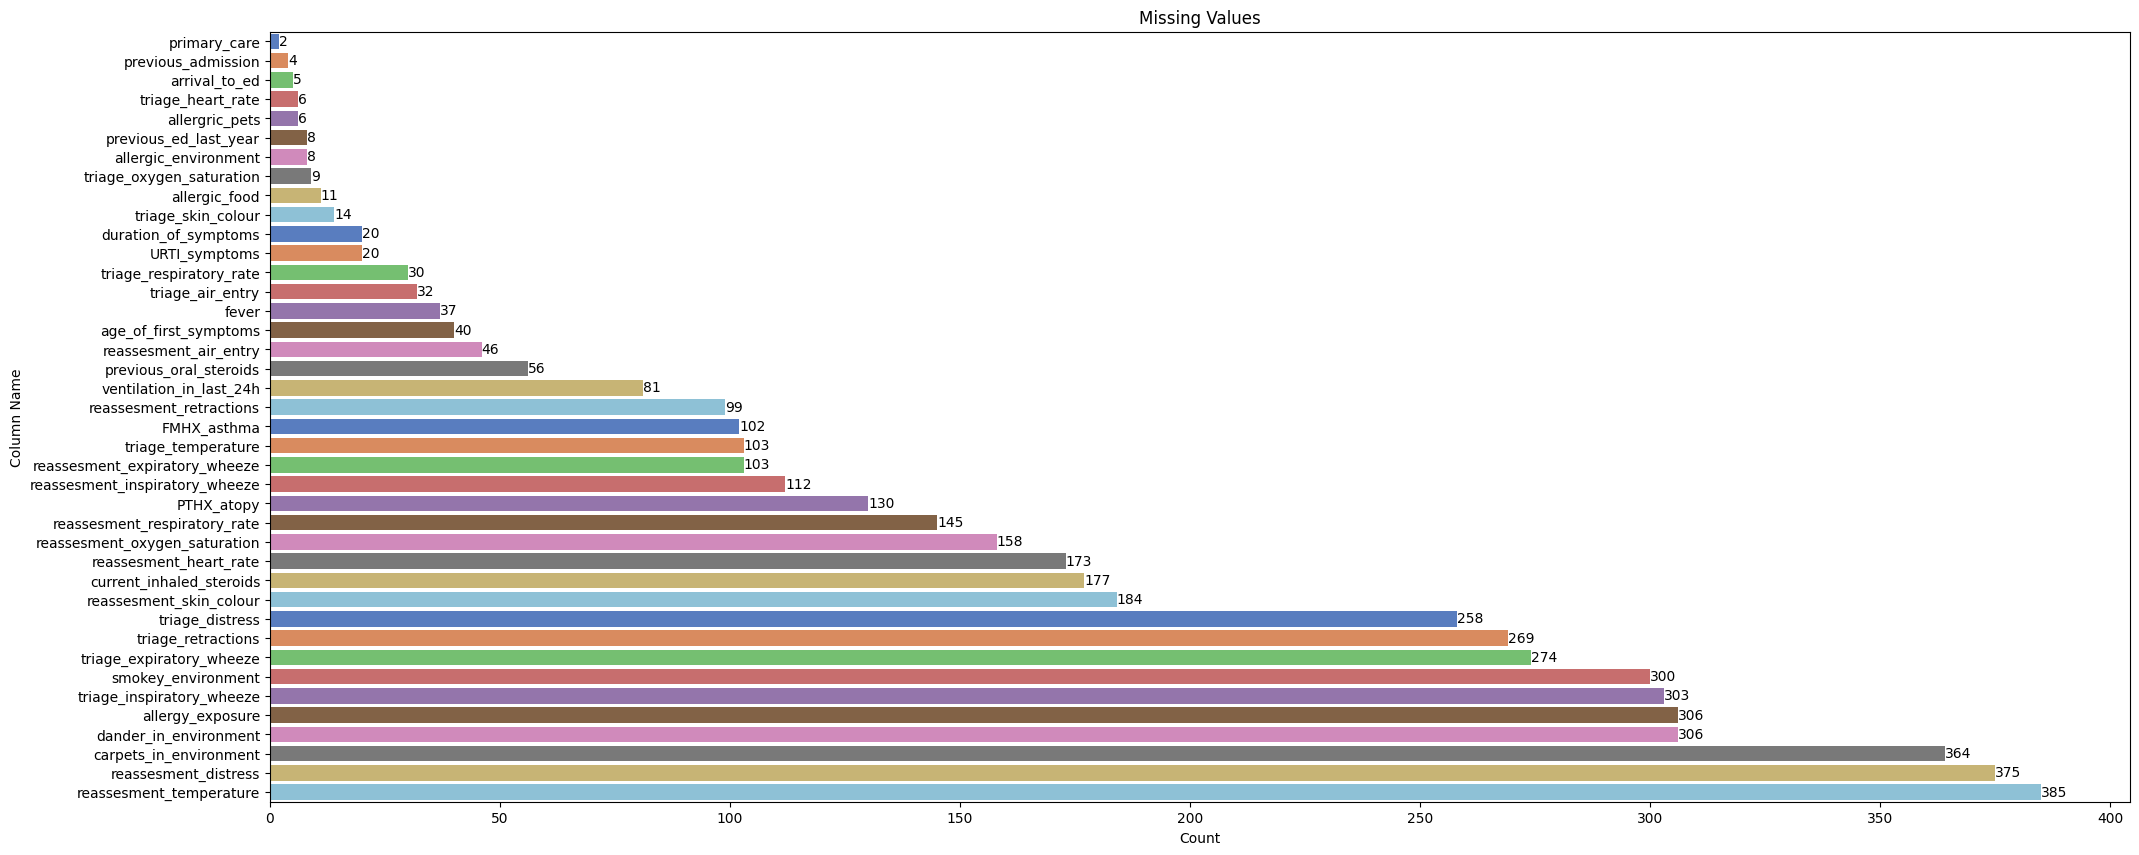

In [125]:
show_missing_values(dataframe)

#### Wykresy - korelacja między atrybutami
Wykres przedstawiający korelację między atrybutami.

C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_34836\267930863.py:93: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


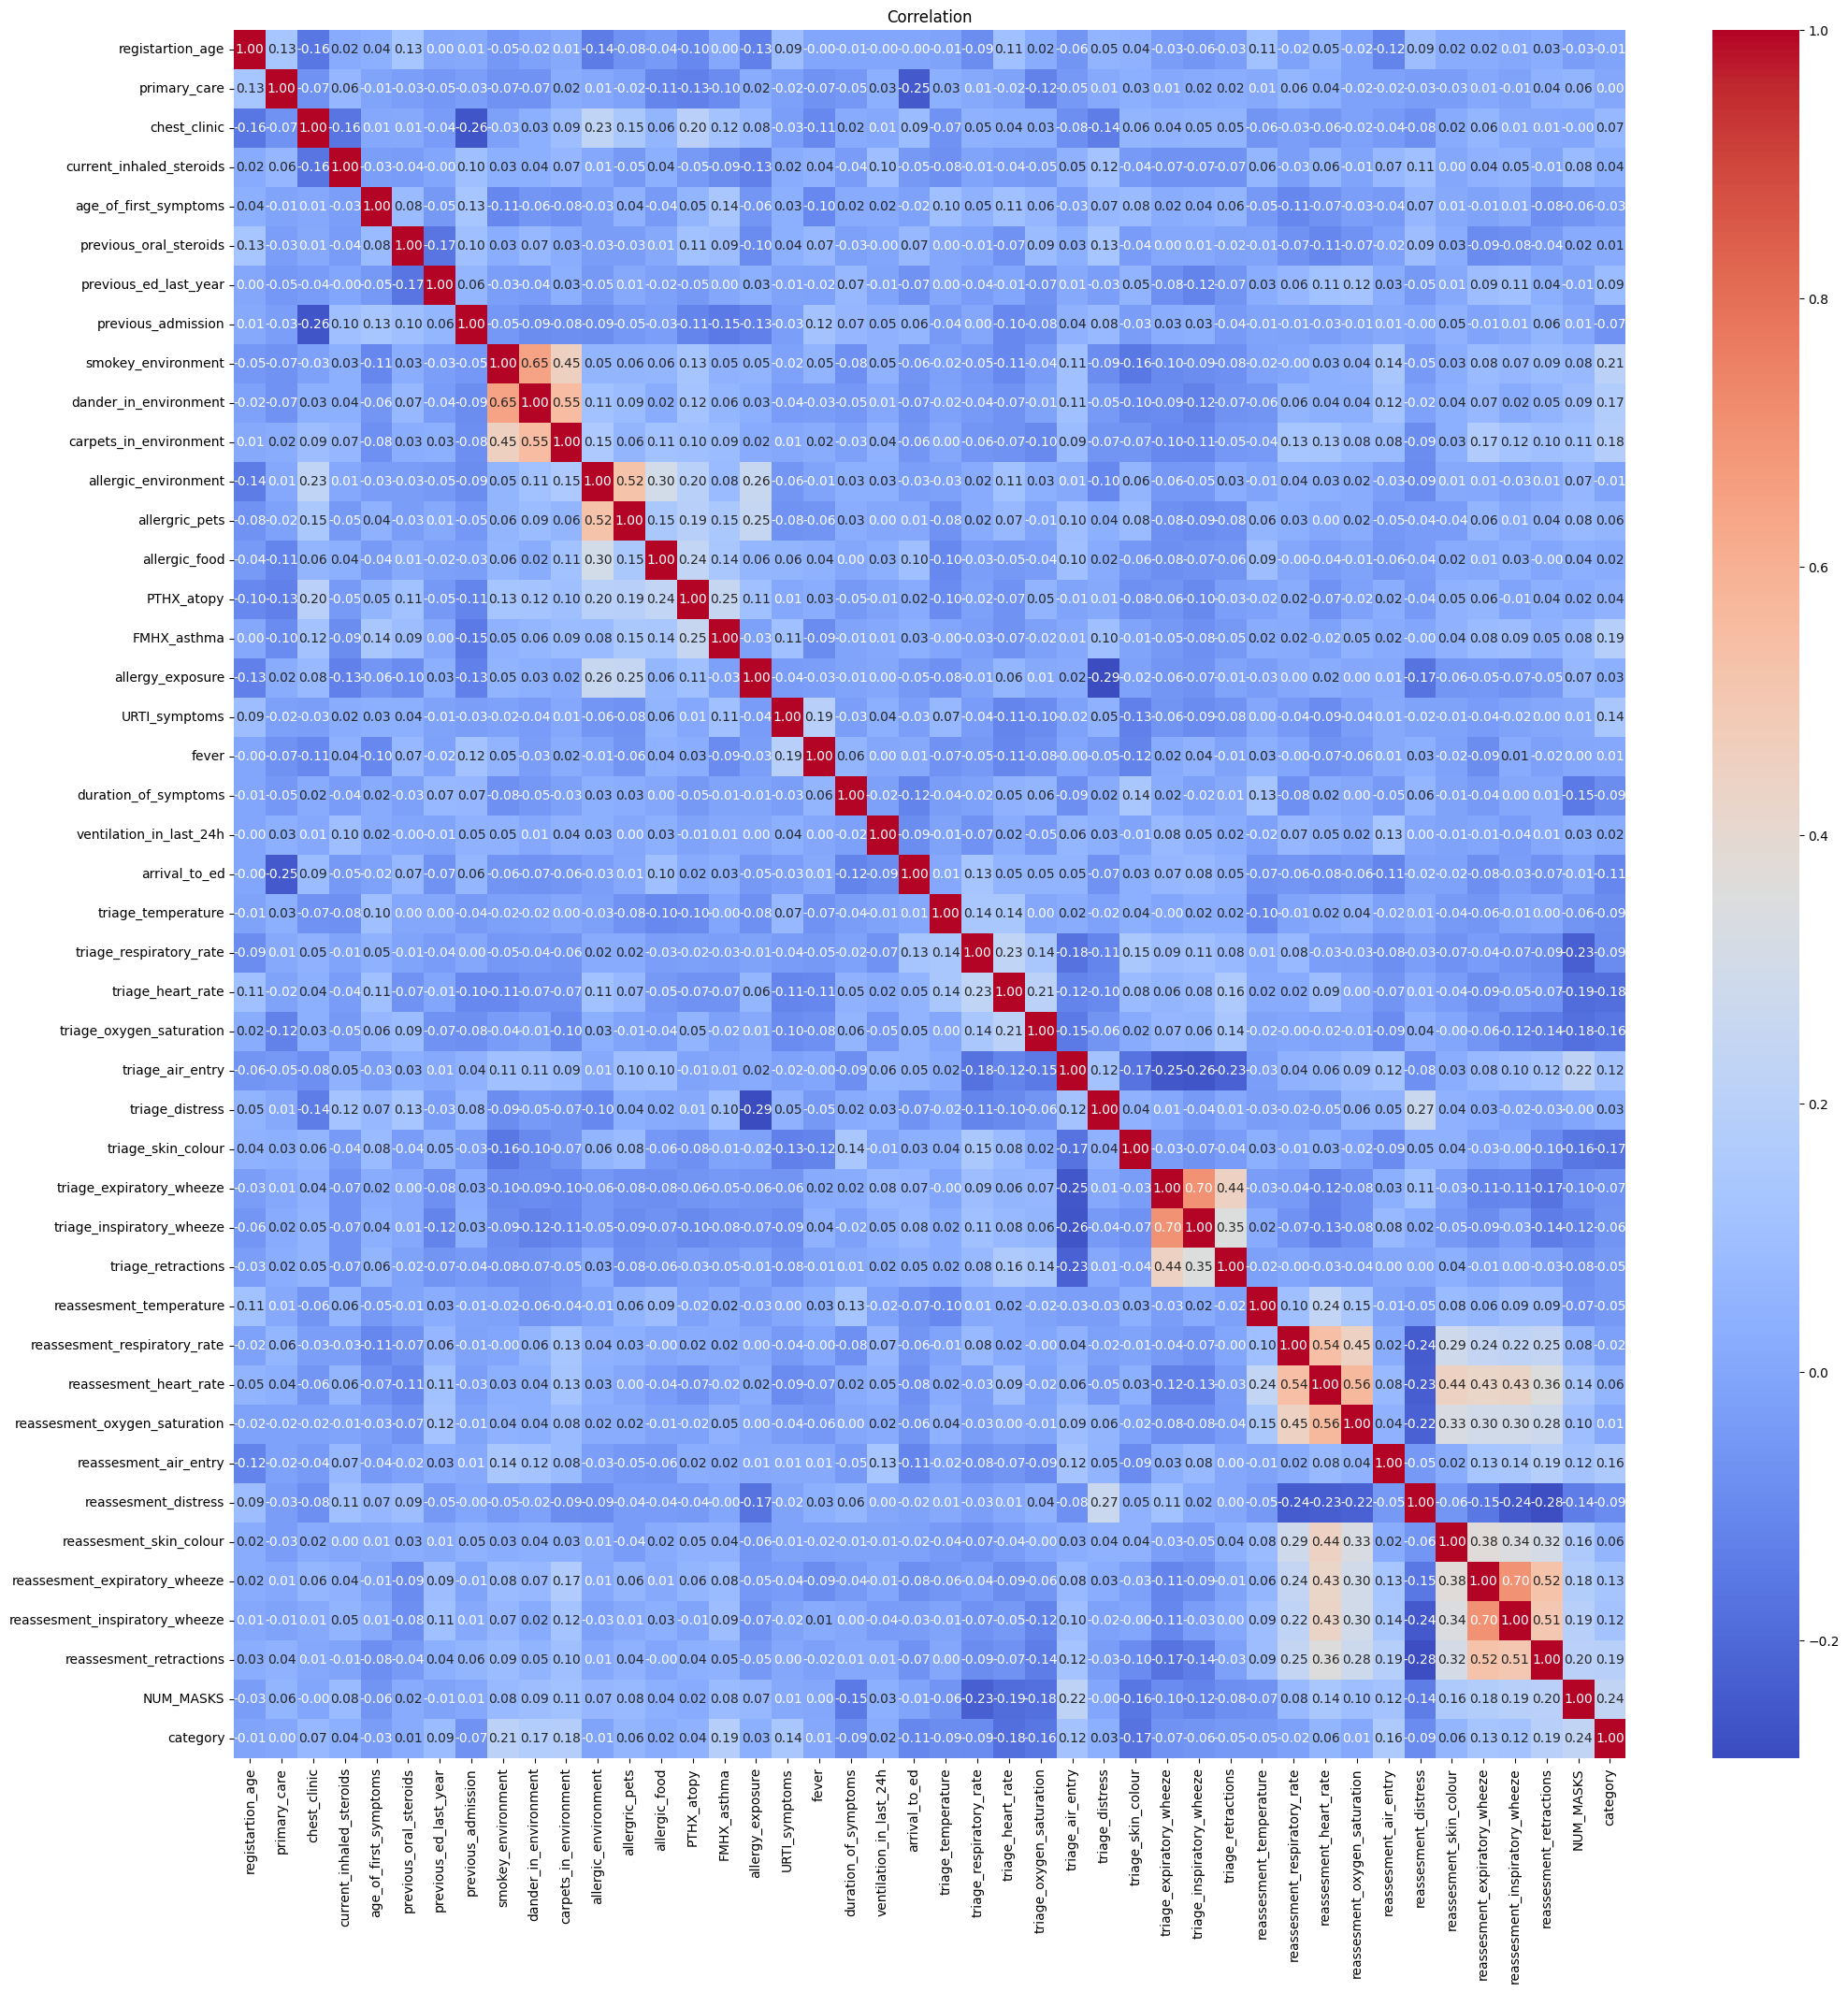

In [126]:
show_correlation(dataframe)

#### Wykresy - rozkład kategorii decyzyjnej

C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_34836\267930863.py:127: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


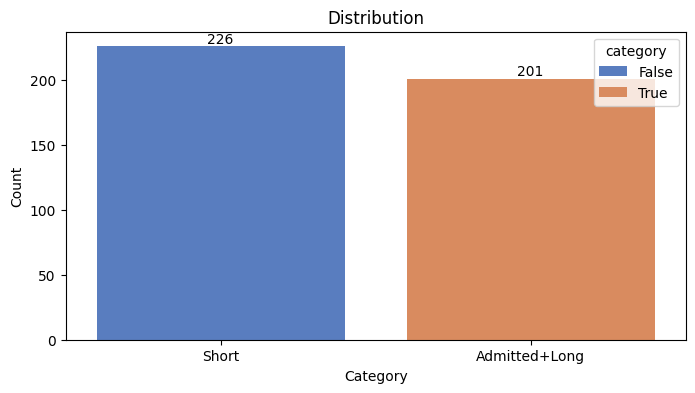

In [127]:
show_distribution(dataframe)

### Przygotowanie danych do modelu

In [128]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

y = dataframe['category']
X = dataframe.drop(columns=['category'])

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.2,
  random_state=42
)


### Model - Regresja Logistyczna

In [129]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{report}')


Accuracy: 0.6162790697674418
Confusion Matrix:
[[30 13]
 [20 23]]
Classification Report:
              precision    recall  f1-score   support

       False       0.60      0.70      0.65        43
        True       0.64      0.53      0.58        43

    accuracy                           0.62        86
   macro avg       0.62      0.62      0.61        86
weighted avg       0.62      0.62      0.61        86


### Model - Random Forest

In [130]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{report}')

Accuracy: 0.6162790697674418
Confusion Matrix:
[[34  9]
 [24 19]]
Classification Report:
              precision    recall  f1-score   support

       False       0.59      0.79      0.67        43
        True       0.68      0.44      0.54        43

    accuracy                           0.62        86
   macro avg       0.63      0.62      0.60        86
weighted avg       0.63      0.62      0.60        86


### Model - SVC (Support Vector Classifier)

In [131]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
  
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{report}')

Accuracy: 0.5697674418604651
Confusion Matrix:
[[29 14]
 [23 20]]
Classification Report:
              precision    recall  f1-score   support

       False       0.56      0.67      0.61        43
        True       0.59      0.47      0.52        43

    accuracy                           0.57        86
   macro avg       0.57      0.57      0.57        86
weighted avg       0.57      0.57      0.57        86
